# Post-estimation Overview - Poisson

This notebook provides an overview of post-estimation results that are available in several models, illustrated for the Poisson Model.

see also https://github.com/statsmodels/statsmodels/issues/7707

Traditionally the results classes for the models provided Wald inference and prediction. Several models now have additional methods for postestimation results, for inference, prediction and specification or diagnostic tests.

The following is based on the current pattern for maximum likelihood models outside tsa, mainly for the discrete models. Other models still follow to some extend a different API pattern. Linear models like OLS and WLS have their special implementation, for example OLS influence. GLM also still has some features that are model specific.

The main post-estimation features are

- Inference - Wald tests [section](#Inference---Wald)
- Inference - score tests [section](#Inference---score_test)
- `get_prediction` prediction with inferential statistics [section](#Prediction)
- `get_distribution` distribution class based on estimated parameters [section](#Distribution)
- `get_diagnostic` diagnostic and specification tests, measures and plots [section](#Diagnostic)
- `get_influence` outlier and influence diagnostics [section](#Outliers-and-Influence)

**Warning** Recently added features are not stable.  
The main features have been unit tested and verified against other statistical packages. However, not every option is fully tested. The API, options, defaults and return types may still change as more features are added. 
(The current emphasis is on adding features and not on finding a convenient and futureproof interface.)



## A simulated example 

For the illustration we simulate data for the Poisson regression, that is correctly specified and has a relatively large sample. One regressor is categorical with two levels, The second regressor is uniformly distributed on the unit interval.


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from statsmodels.discrete.discrete_model import Poisson
from statsmodels.discrete.diagnostic import PoissonDiagnostic

In [2]:
np.random.seed(983154356)

nr = 10
n_groups = 2
labels = np.arange(n_groups)
x = np.repeat(labels, np.array([40, 60]) * nr)
nobs = x.shape[0]
exog = (x[:, None] == labels).astype(np.float64)
xc = np.random.rand(len(x))
exog = np.column_stack((exog, xc))
# reparameterize to explicit constant
# exog[:, 1] = 1
beta = np.array([0.2, 0.3, 0.5], np.float64)

linpred = exog @ beta
mean = np.exp(linpred)
y = np.random.poisson(mean)
len(y), y.mean(), (y == 0).mean()

res = Poisson(y, exog).fit(disp=0)
print(res.summary())

                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                 1000
Model:                        Poisson   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Mon, 20 Jan 2025   Pseudo R-squ.:                 0.01258
Time:                        16:20:35   Log-Likelihood:                -1618.3
converged:                       True   LL-Null:                       -1638.9
Covariance Type:            nonrobust   LLR p-value:                 1.120e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2386      0.061      3.926      0.000       0.120       0.358
x2             0.3229      0.055      5.873      0.000       0.215       0.431
x3             0.5109      0.083      6.186      0.0

## Inference - Wald

Wald tests and other inferential statistics like confidence intervals based on Wald test have been a feature of the models since the beginning. Wald inference is based on the Hessian or expected information matrix evaluted at the estimated parameters.  
The covariance matrix of the parameter is optionally of the sandwich form which is robust to unspecified heteroscedasticity or serial or cluster correlation (`cov_type` option for `fit`).

The currently available methods, aside from the statistics in the parmeter table, are

- t_test
- wald_test
- t_test_pairwise
- wald_test_terms

`f_test` is available as legacy method. It is the same as `wald_test` with keyword option `use_f=True`.

In [3]:
res.t_test("x1=x2")

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0843      0.049     -1.717      0.086      -0.181       0.012

In [4]:
res.wald_test("x1=x2, x3", scalar=True)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=40.772322944293464, p-value=1.4008852592190214e-09, df_denom=2>

## Inference - score_test

new in statsmodels 0.14 for most discrete models and for GLM.

Score or lagrange multiplier (LM) tests are based on the model estimated under the null hypothesis. A common example are variable addition tests for which we estimate the model parameters under null restrictions but evaluate the score and hessian under for the full model to test whether an additional variable is statistically significant.


**Note:** Similar to the Wald tests, the score test implemented in the discrete models and GLM also has the option to use a heteroscedasticity or correlation robust covariance type.  
It currently uses the same implementation and defaults for the robust covariance matrix as in the Wald tests. In some cases the small sample corrections included in the `cov_type` for Wald tests will not be appropriate for score tests. In many cases Wald tests overjects but score tests can underreject. Using the Wald small sample corrections for score tests might leads then to more conservative p-values.  
(The defaults for small sample corrections might change in future. There is currently only little general information available about small sample corrections for heteroscedasticity and correlation robust score tests. Other statistical packages only implement it for a few special cases.)

We can use the variable addition score_test for specification testing. In the following example we test whether there is some misspecified nonlinearity in the model by adding quadratic or polynomial tersm.

In our example we can expect that these specification tests do not reject the null hypotheses because the model is correctly specified and the sample size is large,

In [5]:
res.score_test(exog_extra=xc**2)

(array([0.05300569]), array([0.81791332]), 1)

In [6]:
linpred = res.predict(which="linear")
res.score_test(exog_extra=linpred[:,None]**[2, 3])

(array([1.3867703]), array([0.49988103]), 2)

## Prediction

The model and results classes have `predict` method which only returns the predicted values. The `get_prediction` method adds inferential statistics for the prediction, standard errors, pvalues and confidence intervals.


For the following example, we create new sets of explanatory variables that is split by the categorical level and over a uniform grid of the continuous variable.

In [7]:
n = 11
exc = np.linspace(0, 1, n)
ex1 = np.column_stack((np.ones(n), np.zeros(n), exc))
ex2 = np.column_stack((np.zeros(n), np.ones(n), exc))

m1 = res.get_prediction(ex1)
m2 = res.get_prediction(ex2)

The available methods and attributes of the prediction results class are

In [8]:
[i for i in dir(m1) if not i.startswith("_")]

['conf_int',
 'deriv',
 'df',
 'dist',
 'dist_args',
 'func',
 'linpred',
 'linpred_se',
 'predicted',
 'row_labels',
 'se',
 'summary_frame',
 't_test',
 'tvalues',
 'var_pred']

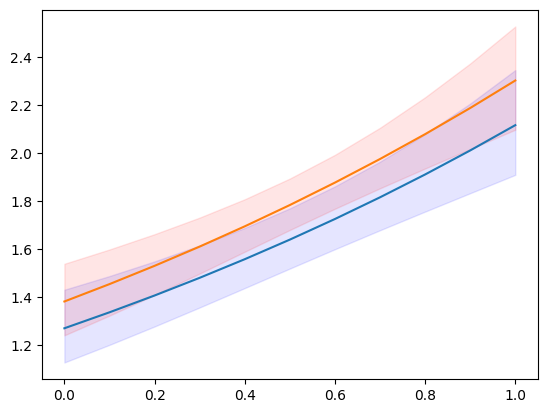

In [9]:
plt.plot(exc, np.column_stack([m1.predicted, m2.predicted]))
ci = m1.conf_int()
plt.fill_between(exc, ci[:, 0], ci[:, 1], color='b', alpha=.1)
ci = m2.conf_int()
plt.fill_between(exc, ci[:, 0], ci[:, 1], color='r', alpha=.1)
# to add observed points:
# y1 = y[x == 0]
# plt.plot(xc[x == 0], y1, ".", color="b", alpha=.3)
# y2 = y[x == 1]
# plt.plot(xc[x == 1], y2, ".", color="r", alpha=.3)

In [10]:
y.max()

np.int64(7)

One of the available statistics that we can predict, specified by the "which" keyword, is the expected frequencies or probabilities of the predictive distribution. This shows us what the predicted probability of obsering count = 1, 2, 3, ... is for a given set of explanatory variables.

In [11]:
y_max = 5
f1 = res.get_prediction(ex1, which="prob", y_values=np.arange(y_max + 1))
f2 = res.get_prediction(ex2, which="prob", y_values=np.arange(y_max + 1))
f1.predicted.mean(0), f2.predicted.mean(0)

(array([0.19681697, 0.31325239, 0.25570764, 0.14275759, 0.06128168,
        0.02154715]),
 array([0.17115113, 0.29529781, 0.26128059, 0.15810937, 0.07357482,
        0.02804883]))

We can also get the confidence intervals for the predicted probabilities.
However, if we want the confidence interval for the average predicted probabilities, then we need to aggregate inside the predict function. The relevant keyword is "average" which computes the average of the predictions over the observations given by the `exog` array.

In [12]:
f1 = res.get_prediction(ex1, which="prob", y_values=np.arange(y_max + 1), average=True)
f2 = res.get_prediction(ex2, which="prob", y_values=np.arange(y_max + 1), average=True)
f1.predicted, f2.predicted

(array([0.19681697, 0.31325239, 0.25570764, 0.14275759, 0.06128168,
        0.02154715]),
 array([0.17115113, 0.29529781, 0.26128059, 0.15810937, 0.07357482,
        0.02804883]))

In [13]:
f1.conf_int()

array([[0.17256941, 0.22106453],
       [0.2982307 , 0.32827408],
       [0.24818616, 0.26322912],
       [0.12876732, 0.15674787],
       [0.05088296, 0.07168041],
       [0.01626921, 0.0268251 ]])

In [14]:
f2.conf_int()

array([[0.15303084, 0.18927142],
       [0.28178041, 0.30881522],
       [0.25622062, 0.26634055],
       [0.14720224, 0.1690165 ],
       [0.06442055, 0.0827291 ],
       [0.02287077, 0.03322688]])

To get more information about the predict methods and the available options, see  
`help(res.get_prediction)`  
`help(res.model.predict)`  

## Distribution

For given parameters we can create an instance of a scipy or scipy-compatible distribution class. This provides us with access to any of the methods in the distribution, pmf/pdf, cdf, stats.

The `get_distribution` method of the results class uses the provided array of explanatory variables and the estimated parameters to specify a vectorized distribution. The `get_prediction` method of the model can be used for user specified parameters `params`.

In [15]:
distr = res.get_distribution()
distr

In [16]:
distr.pmf(0)[:10]

array([0.15420516, 0.13109359, 0.17645042, 0.16735421, 0.13445031,
       0.14851843, 0.22287053, 0.14979318, 0.25252986, 0.25013583])

The mean of the conditional distribution is the same as the predicted mean from the model.

In [17]:
distr.mean()[:10]

array([1.86947133, 2.03184379, 1.73471534, 1.78764267, 2.00656061,
       1.90704623, 1.50116427, 1.89849971, 1.37622577, 1.3857512 ])

In [18]:
res.predict()[:10]

array([1.86947133, 2.03184379, 1.73471534, 1.78764267, 2.00656061,
       1.90704623, 1.50116427, 1.89849971, 1.37622577, 1.3857512 ])

We can also obtain the distribution for a new set of explanatory variables. Explanatory variables can be provided in the same way as for the predict method.

We use again the grid of explanatory variables from the prediction section. As example for its usage we can compute the probability that a count (strictly) larger than 5 will be observed conditional on the values of the explanatory variables.

In [19]:
distr1 = res.get_distribution(ex1)
distr2 = res.get_distribution(ex2)

In [20]:
distr1.sf(5), distr2.sf(5)

(array([0.00198421, 0.00255027, 0.00326858, 0.00417683, 0.00532093,
        0.00675641, 0.00854998, 0.01078116, 0.0135439 , 0.01694825,
        0.02112179]),
 array([0.00299758, 0.00383456, 0.00489029, 0.00621677, 0.00787663,
        0.00994468, 0.01250966, 0.01567579, 0.01956437, 0.02431503,
        0.03008666]))

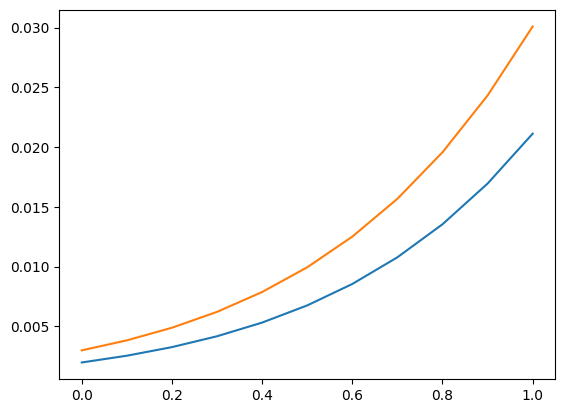

In [21]:
plt.plot(exc, np.column_stack([distr1.sf(5), distr2.sf(5)]))

We can also use the distribution to find an upper confidence limit on a new observation. The following plot and table show the upper limit counts for given explanatory variables. The probability of observing this count or less is at least 0.99. 

Note, this takes parameters as fixed and does not take parameter uncertainty into account.

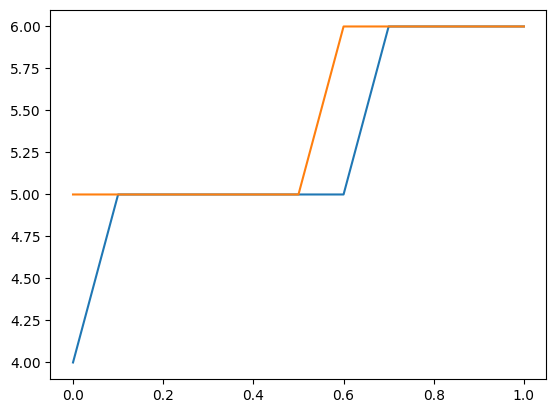

In [22]:
plt.plot(exc, np.column_stack([distr1.ppf(0.99), distr2.ppf(0.99)]))

In [23]:
[distr1.ppf(0.99), distr2.ppf(0.99)]

[array([4., 5., 5., 5., 5., 5., 5., 6., 6., 6., 6.]),
 array([5., 5., 5., 5., 5., 5., 6., 6., 6., 6., 6.])]

## Diagnostic

Poisson is the first model that has a diagnostic class that can be obtained from the results using `get_diagnostic`. Other count models have a generic count diagnostic class that has currently only a limited number of methods.

The Poisson model in our example is correctly specified. Additionally we have a large sample size. So, in this case none of the diagnostic tests reject the null hypothesis of correct specification.

In [24]:
dia = res.get_diagnostic()
[i for i in dir(dia) if not i.startswith("_")]

['plot_probs',
 'probs_predicted',
 'results',
 'test_chisquare_prob',
 'test_dispersion',
 'test_poisson_zeroinflation',
 'y_max']

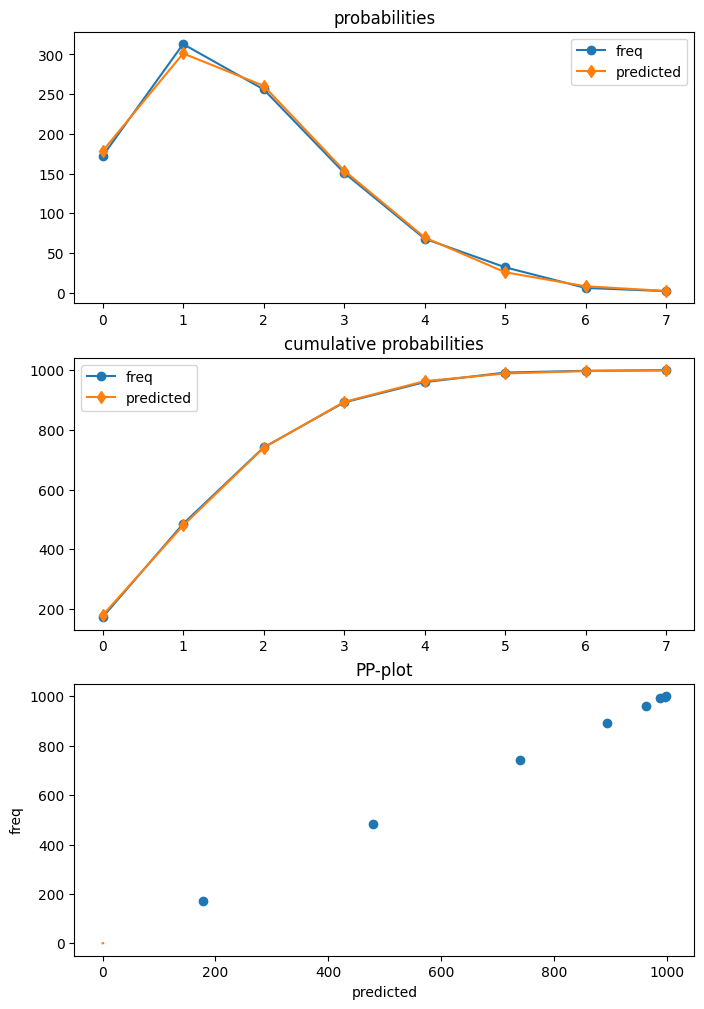

In [25]:
dia.plot_probs();

**test for excess dispersion**

There are several dispersion tests available for Poisson. Currently all of them are returned.
The DispersionResults class has a summary_frame method. The returned dataframe provides an overview of the results that is  easier to read.

In [26]:
td = dia.test_dispersion()
td

<class 'statsmodels.discrete._diagnostics_count.DispersionResults'>
statistic = array([-0.42597379, -0.42597379, -0.39884024, -0.48327447, -0.48327447,
           -0.47790855, -0.45225818])
pvalue = array([0.67012695, 0.67012695, 0.69001092, 0.62890087, 0.62890087,
           0.6327153 , 0.651083  ])
method = ['Dean A', 'Dean B', 'Dean C', 'CT nb2', 'CT nb1', 'CT nb2 HC3', 'CT nb1 HC3']
alternative = ['mu (1 + a mu)', 'mu (1 + a mu)', 'mu (1 + a)', 'mu (1 + a mu)', 'mu (1 + a)', 'mu (1 + a mu)', 'mu (1 + a)']
name = 'Poisson Dispersion Test'
tuple = (array([-0.42597379, -0.42597379, -0.39884024, -0.48327447, -0.48327447,
           -0.47790855, -0.45225818]), array([0.67012695, 0.67012695, 0.69001092, 0.62890087, 0.62890087,
           0.6327153 , 0.651083  ]))

In [27]:
df = td.summary_frame()
df

,statistic,pvalue,method,alternative
0,-0.425974,0.670127,Dean A,mu (1 + a mu)
1,-0.425974,0.670127,Dean B,mu (1 + a mu)
2,-0.398840,0.690011,Dean C,mu (1 + a)
3,-0.483274,0.628901,CT nb2,mu (1 + a mu)
4,-0.483274,0.628901,CT nb1,mu (1 + a)
5,-0.477909,0.632715,CT nb2 HC3,mu (1 + a mu)
6,-0.452258,0.651083,CT nb1 HC3,mu (1 + a)


**test for zero-inflation**

In [28]:
dia.test_poisson_zeroinflation()

<class 'statsmodels.stats.base.HolderTuple'>
statistic = np.float64(-0.6657556201098714)
pvalue = np.float64(0.5055673158225651)
pvalue_smaller = np.float64(0.7472163420887175)
pvalue_larger = np.float64(0.25278365791128254)
chi2 = np.float64(0.44323054570787945)
pvalue_chi2 = np.float64(0.505567315822565)
df_chi2 = 1
distribution = 'normal'
tuple = (np.float64(-0.6657556201098714), np.float64(0.5055673158225651))

chisquare test for zero-inflation

In [29]:
dia.test_chisquare_prob(bin_edges=np.arange(3))

<class 'statsmodels.stats.base.HolderTuple'>
statistic = np.float64(0.456170941873113)
pvalue = np.float64(0.4994189468121014)
df = np.int64(1)
diff1 = array([[-0.15420516,  0.71171787],
           [-0.13109359, -0.26636169],
           [-0.17645042, -0.30609125],
           ...,
           [-0.10477112, -0.23636125],
           [-0.10675436, -0.2388335 ],
           [-0.21168332, -0.32867305]], shape=(1000, 2))
res_aux = <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fc5b6b22b90>
distribution = 'chi2'
tuple = (np.float64(0.456170941873113), np.float64(0.4994189468121014))

**goodness of fit test for predicted frequencies**

This is a chisquare test that takes into account that parameters are estimated.
Counts larger than the largest bin edge will be added to the last bin, so that the sum over bins is one.

For example using 5 bins

In [30]:
dt = dia.test_chisquare_prob(bin_edges=np.arange(6))
dt

<class 'statsmodels.stats.base.HolderTuple'>
statistic = np.float64(0.9414641297779136)
pvalue = np.float64(0.9185382008345917)
df = np.int64(4)
diff1 = array([[-0.15420516,  0.71171787, -0.26946759, -0.16792064, -0.07848071],
           [-0.13109359, -0.26636169, -0.27060268,  0.81672588, -0.0930961 ],
           [-0.17645042, -0.30609125,  0.7345094 , -0.15351687, -0.06657702],
           ...,
           [-0.10477112, -0.23636125, -0.26661279,  0.79950922, -0.11307565],
           [-0.10675436, -0.2388335 ,  0.73283789, -0.1992339 , -0.11143275],
           [-0.21168332, -0.32867305,  0.74484061, -0.13205892, -0.05126078]],
          shape=(1000, 5))
res_aux = <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fc5b6b4e050>
distribution = 'chi2'
tuple = (np.float64(0.9414641297779136), np.float64(0.9185382008345917))

In [31]:
dt.diff1.mean(0)

array([-0.00628136,  0.01177308, -0.00449604, -0.00270524, -0.00156519])

In [32]:
vars(dia)

{'results': <statsmodels.discrete.discrete_model.PoissonResults at 0x7fc5bb343310>,
 'y_max': None,
 '_cache': {'probs_predicted': array([[0.15420516, 0.28828213, 0.26946759, ..., 0.02934349, 0.0091428 ,
          0.00244174],
         [0.13109359, 0.26636169, 0.27060268, ..., 0.03783135, 0.01281123,
          0.00371863],
         [0.17645042, 0.30609125, 0.2654906 , ..., 0.02309843, 0.0066782 ,
          0.00165497],
         ...,
         [0.10477112, 0.23636125, 0.26661279, ..., 0.05101921, 0.01918303,
          0.00618235],
         [0.10675436, 0.2388335 , 0.26716211, ..., 0.04986002, 0.01859135,
          0.00594186],
         [0.21168332, 0.32867305, 0.25515939, ..., 0.01591815, 0.00411926,
          0.00091369]], shape=(1000, 8))}}

## Outliers and Influence

Statsmodels provides a general MLEInfluence class for nonlinear models (models with nonlinear expected mean) that for the discrete models and other maximum likelihood based models such as the Beta regression model.
The provided measures are based on general definitions, for example generalized leverage instead of the diagonal of the hat matrix in linear models.

The results method `get_influence` returns and instance of the MLEInfluence class which has various methods for outlier and influence measures. 


In [33]:
infl = res.get_influence()
[i for i in dir(infl) if not i.startswith("_")]

['cooks_distance',
 'cov_params',
 'd_fittedvalues',
 'd_fittedvalues_scaled',
 'd_params',
 'dfbetas',
 'endog',
 'exog',
 'hat_matrix_diag',
 'hat_matrix_exog_diag',
 'hessian',
 'k_params',
 'k_vars',
 'model_class',
 'nobs',
 'params_one',
 'plot_index',
 'plot_influence',
 'resid',
 'resid_score',
 'resid_score_factor',
 'resid_studentized',
 'results',
 'scale',
 'score_obs',
 'summary_frame']

The influence class has two plot methods. However, the plots are too crowded in this case because of the large sample size.

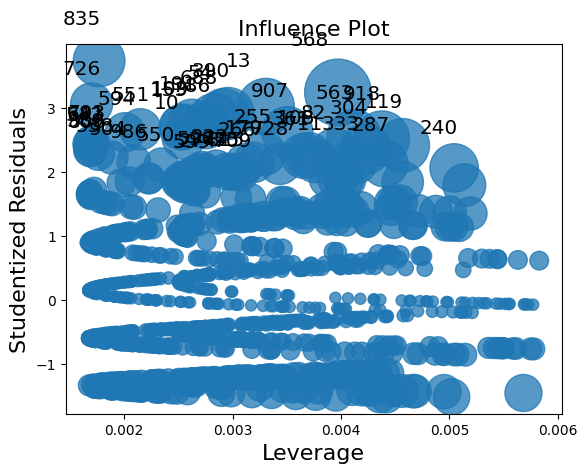

In [34]:
infl.plot_influence();

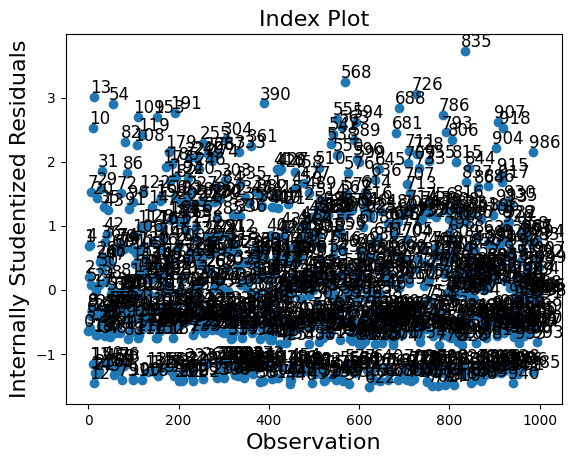

In [35]:
infl.plot_index(y_var="resid_studentized");

A `summary_frame` shows the main influence and outlier measures for each observations.

We have 1000 observations in our example which is too many to easily display. We can sort the summary dataframe by one of the columns and list the observations with the largest outlier or influence measure. In the example below, we sort by Cook's distance and by `standard_resid` which is the Pearson residual in the generic case.

Because we simulated a "nice" model, there are no observations with large influence or that are large outliers.

In [36]:
df_infl = infl.summary_frame()
df_infl.head()

,dfb_x1,dfb_x2,dfb_x3,cooks_d,standard_resid,hat_diag,dffits_internal
0,-0.010856,0.011384,-0.013643,0.000440,-0.636944,0.003243,-0.036334
1,0.001990,-0.023625,0.028313,0.000737,0.680823,0.004749,0.047031
2,0.005794,-0.000787,0.000943,0.000035,0.201681,0.002607,0.010311
3,-0.014243,0.005539,-0.006639,0.000325,-0.589923,0.002790,-0.031206
4,0.003602,-0.022549,0.027024,0.000738,0.702888,0.004462,0.047057


In [37]:
df_infl.sort_values("cooks_d", ascending=False)[:10]

,dfb_x1,dfb_x2,dfb_x3,cooks_d,standard_resid,hat_diag,dffits_internal
568,-0.110520,-0.038997,0.143106,0.013922,3.236167,0.003972,0.204365
13,0.048914,-0.056713,0.067969,0.010034,3.011778,0.003307,0.173497
918,-0.093971,-0.038431,0.121677,0.009304,2.519367,0.004378,0.167066
563,-0.089917,-0.033708,0.116428,0.008935,2.545624,0.004119,0.163720
119,0.163230,0.103957,-0.124589,0.008883,2.409646,0.004569,0.163247
390,0.148697,0.066972,-0.080264,0.008358,2.907190,0.002958,0.158345
835,-0.017672,0.066475,0.022883,0.008209,3.727645,0.001769,0.156931
54,0.145944,0.064216,-0.076961,0.008156,2.892554,0.002916,0.156419
907,-0.078901,-0.020908,0.102164,0.008021,2.615676,0.003505,0.155126
304,0.152905,0.093680,-0.112272,0.007821,2.351520,0.004225,0.153179


In [38]:
df_infl.sort_values("standard_resid", ascending=False)[:10]

,dfb_x1,dfb_x2,dfb_x3,cooks_d,standard_resid,hat_diag,dffits_internal
835,-0.017672,0.066475,0.022883,0.008209,3.727645,0.001769,0.156931
568,-0.110520,-0.038997,0.143106,0.013922,3.236167,0.003972,0.204365
726,-0.003941,0.065200,0.005103,0.005303,3.056406,0.001700,0.126127
13,0.048914,-0.056713,0.067969,0.010034,3.011778,0.003307,0.173497
390,0.148697,0.066972,-0.080264,0.008358,2.907190,0.002958,0.158345
54,0.145944,0.064216,-0.076961,0.008156,2.892554,0.002916,0.156419
688,0.083205,0.148254,-0.107737,0.007606,2.833988,0.002833,0.151057
191,0.122062,0.040388,-0.048403,0.006704,2.764369,0.002625,0.141815
786,-0.061179,-0.000408,0.079217,0.006827,2.724900,0.002751,0.143110
109,0.110999,0.029401,-0.035236,0.006212,2.704144,0.002542,0.136518
